<hr>
Este material ha sido construido en conjunto con material suministrado por los profesores Pedro Atencio (Instituto Tecnológico Metropolitano), Carlos Mera (Universidad de Medellin), Albeiro Espinosa y Diego Patiño (Universidad Nacional de Colombia, Sede Medellín); a ellos les damos crédito.
<hr>

#  <center> VISIÓN ARTIFICIAL </center>
## Agenda del día


### Unidad 6 - Perfilado, Extracción de Bordes y Segmentación


<ul>
  <li>Perfilado</li>
  <li>Extracción de bordes</li>
  <li>Segmentación</li>


</ul>

In [ ]:
### UTILIDADES PARA LA LECTURA DE IMÁGENES

#Importar librerías
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Función de lectura rápida de imágenes a color y en escala de grises
def img_read(filename, mode = 'color'):
    if(mode == 'color'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

    #Función para interpolar los puntos entre 0 y 255
def img_scale(img, value_range = [0,255]):
    return (value_range[1] - value_range[0])*(img - np.min(img))/(np.max(img)-np.min(img)) + value_range[0]

    #Función para enviar los extremos superior e inferior a 0 y 255 respectivamente en la matriz
def img_trim(img, value_range = [0, 255]):
    res = img.copy()
    res[res > 255] = 255
    res[res < 0] = 0
    return res

![image.png](attachment:image.png)

# 0. REPASO DE CONVOLUCIÓN

Este tipo de transformaciones operan sobre un conjunto de valores sobre el pixel principal. Su propósito es resaltar o atenuar los detalles espaciales de la imagen para mejorar su interpretación visual o facilitar su procesamiento posterior. Para ello se usan diferentes mascaras de convolución, que pueden expresarse de la siguiente forma:
<br>
<center><h3>$G(x,y) = f(I(x-k, y-k),...,I(x+k,y+k))$</h3></center>
<br>
Donde k, se refiere al radio de una ventana alrededor del píxel central en la posición (x,y).
<br>
<center><i>Figura. Convolución con kernel. Tomada de <a href='https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/ConvolutionOperations/ConvolutionOperations.html'>apple developer.</a></i></center>
<img src="res/convolucion/image_convolution.jpg" alt="operaciones" style="height:400px"></img>
<br>
Si bien una convolución se puede realizar solo con los valores de la imagen de entrada I, su expresión general requiere de un kernel de convolución, el cual es una matriz usualmente cuadrada de menor tamaño que la imagen que se está operando. En este caso, la operación de convolución en su forma general queda expresada como:
<br>
<center><h2>$G(x,y)=\sum_{i=-k}^{k}\sum_{j=-k}^{k}I(x+i,y+j)*w(k+i, k+j)$</h2></center>
<br>
Donde k es el radio del kernel de convolución w, cuyo tamaño es cuadrado e impar.
<hr>


In [2]:
#Importar librerías

%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

#Se genera un kernel de tamaño size.
#Se devuelve el radio del kernel r.
#Se devuelve el kernel como tal, dividido entre
#la cantidad total de posiciones en este: size^2.
def make_kernel(k_size):
    kernel = np.ones((k_size, k_size),
                     dtype=np.float32) #Generamos un kernel con tipo de dato float
                                                        #para poder almacenar datos reales.
    r = math.floor(k_size/2)           #El radio del kernel se obtiene redondenado hacia abajo
                                        #la división del tamaño del kernel sobre dos.
    return r,kernel/(k_size**2)


img = img_read('res/camera.png', 'gray')
k_size = 9
(r, kernel) = make_kernel(k_size)

#Creamos una imagen destino para la convolución, del mismo tamaño que la original.
res = np.zeros(img.shape, dtype=np.float32)

#Para cada píxel se recorre un vecindario con un rango de
#r píxeles a la izquierda, a la derecha, arriba y
#abajo del mismo.
def apply_kernel(img, res, x,y,kernel,r):
    for i in range(-r, r+1):
        for j in range(-r, r+1):
            res[x][y] += img[x+i][y+j] * kernel[r+i][r+j]


#Se hace un recorrido de la imagen.
#Al introducir el valor de r en el ciclo for, se evita que se intente convolucionar
#píxeles cuyo valor no está definido.
for i in range(r,img.shape[0]-r):
    for j in range(r, img.shape[1]-r):
        apply_kernel(img, res, i, j, kernel, r)

res=res.astype(np.uint8)

#Generar un subplot 1x2 para mostrar la imagen original y la imagen convolucionada
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen convolucionada')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255)

NameError: name 'img_read' is not defined

# 1. PERFILADO / REALZADO

Los filtros de realzado (o Paso Alto) se usan para resaltar los detalles “finos” de la imagen y/o para recuperar cierto detalle perdido durante su captura. Es por esta razón que están asociados con la detección de bordes.

¿Qué se obtiene si a una imagen f(x,y) se le resta una imagen f’(x,y) que corresponde a la imagen f(x,y) filtrada con un filtro de suavizado?

Un proceso que se ha utilizado durante muchos años en la industria de la publicidad es realzar una imagen restando a la imagen original una versión borrosa de la misma y luego sumando el resultado de esta operación a la imagen original. A este proceso se le denomina Máscara Unsharp y se expresa así:
<br/>

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [3]:
#Importar librerías
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np

#Leer la imagen de entrada
img = img_read("res/camera.png", "gray")

#Dar tamaño al kernel
k_size = 5

#Se le aplica a la imagen un filtro Gaussiano con un kernel de tamaño k_size x k_size,
#y con un sigma de 2.
gaussian = cv2.GaussianBlur(img, (k_size,k_size), 2)

#Crear la máscara que corresponde a la resta entre la imagen original y el filtro gaussiano
mascara_unsharp = cv2.subtract(img, gaussian)

#Sumar la imagen de entrada con la máscara
res = cv2.add(img, mascara_unsharp)

#Generar un subplot 2x2 para mostrar imagen original, con filtro gaussiano, la máscara y el resultado
fig, arreglo_plots = plt.subplots(2,2, figsize=(15, 15), dpi = 500)

arreglo_plots[0][0].set_title('Imagen original')
arreglo_plots[0][0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[0][1].set_title('Imagen con filtro gaussiano')
arreglo_plots[0][1].imshow(gaussian, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1][0].set_title('Máscara unsharp')
arreglo_plots[1][0].imshow(mascara_unsharp, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1][1].set_title('Resultado')
arreglo_plots[1][1].imshow(res, cmap="gray", vmin=0, vmax=255)

NameError: name 'img_read' is not defined

# 2 EXTRACCIÓN DE BORDES


## 2.1 INTRODUCCIÓN

La extracción de bordes es una operacion muy útil en el procesamiento de imágenes digitales y la visión por computador, ya que un alto porcentaje de la información original de la imagen puede ser derivada a partir de los bordes, esto es, los bordes presentan alto contenido informativo. De esta forma, procesar la imagen utilizando solo los bordes puede ayudar a reducir el costo computacional.

### ¿QUÉ ES UN BORDE?

En una imágen digital, se pueden entender los píxeles de borde o contorno, como aquellos píxeles alrededor de los cuales se presenta una variación brusca de niveles de intensidad.
<br><br>
Un borde en una imagen esta relacionado con:
<ul>
    <li>Contornos de objetos sólidos.</li>
    <li>Sombras.</li>
    <li>Marcas.</li>
    <li><font color='red'>Ruido</font></li>
</ul>

<center><i>Figura. Naturaleza de los bordes.</i></center>
<img src="res/M7/bordes_naturaleza.png\" alt="" style="width:700px">
<br>
<center><i>Figura. Naturaleza de los bordes.</i></center>
<img src="res/M7/bordes_naturaleza_2.png\" alt="" style="width:700px">
<br>
<center><i>Figura. Efecto del ruido en la deteccion de bordes.</i></center>
<img src="res/M7/bordes_ruido.png\" alt="" style="height:300px">
<br><br>

Hay <b>tres tipos básicos de discontinuidades</b> que se tienden a buscar en las imágenes digitales (generalmente co base en el concepto de las derivadas): <font color='red'>Puntos, Líneas (horizontales, verticales o en diagonal) y Bordes</font> que son píxeles en la posición de un contorno entre dos regiones (en cambio significativo en la intensidad local en la imagen). La naturaleza de estas discontinuidades requiere aproximaciones distintas para su extracción según la aplicación.
<br>

<center><i>Figura. Tipos de bordes.</i></center>
<img src="res/M7/bordes_tipos.png\" alt="" style="height:250px">

<hr>

## 2.2. EXTRACCIÓN
<br>
Extracción se refiere al proceso de obtener los bordes en una imagen digital aplicando operadores de algún tipo. Esta extracción generalmente se realiza mediante una máscara o kernel y el proceso de convolución.
<br>


### CONVOLUCIÓN PARA LA DETECCIÓN DE PUNTOS
<br>
Para detectar puntos aislados cuyo nivel de gris es significativamente diferente del fondo, situado en una zona casi homogénea, se suele utilizar una máscara Laplaciana:
<br>
<center><i>Figura. Aplicación de máscara Laplaciana para la extracción de puntos aislados.</i></center>
<img src="res/M7/laplaciana.png\" alt="" style="width:800px">

In [4]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#Leer la imagen de entrada
img = img_read('./res/M7/degradado.png', "gray").astype(np.float32)

#Crear las máscaras 1 y 2 e imprimirlas, corresponden a matrices cuadradas
mask1 = np.array([[-1,-1,-1],
                 [-1,8,-1],
                 [-1,-1,-1]])

mask2 = np.ones([5,5])
mask2 = mask2 * -1
mask2[2,2] = 24

print("Máscara 1:")
print(mask1)

print("\nMáscara 2:")
print(mask2)



NameError: name 'img_read' is not defined

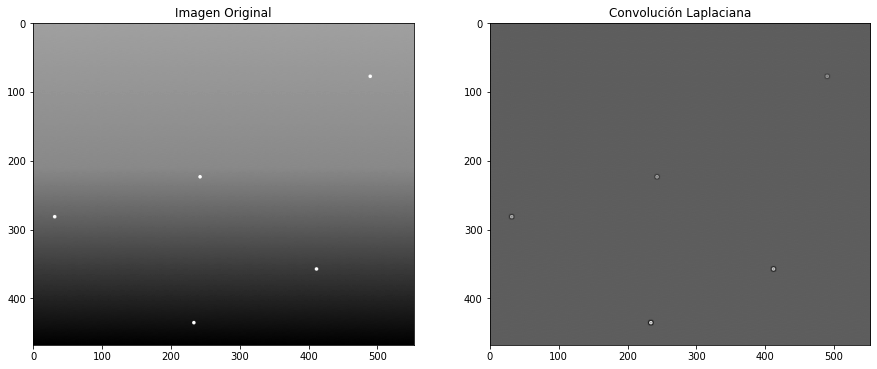

In [ ]:
#La función cv2.filter2D recibe la imagen, un parámetro ddepth que dejamos en -1, y el kernel.
#También se puede definir el tipo de borde que se desee tener en cuenta para la convolución.
laplace_filtered = cv2.filter2D(img, ddepth = -1, kernel=mask2, borderType = cv2.BORDER_REPLICATE)

#Generar un subplot 1x2 para mostrar imagen de entrada y convolución Laplaciana
fig, ax = plt.subplots(1,2, figsize=(15, 8))
ax[0].set_title('Imagen Original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Convolución Laplaciana')
ax[1].imshow((laplace_filtered), cmap='gray')

In [ ]:
print(np.max(laplace_filtered))

1891.0


Generalmente, las técnicas de detección de puntos y líneas basadas en convolución no conservan la escala de valores original de la imagen. Por esto se hace necesario aplicar una poda una vez se haya operado con estas.

Para este propósito se presenta la función *img_trim*, que toma un rango de valores (por defecto es 0~255). Esta función simplemente asigna el valor mínimo del rango dado a los valores de la imagen que estén por debajo y actúa de manera similar para los que estén por encima.

Otra opción es escalar los valores a un rango dado, tal como:

 # <center> $ X_{new} = \frac{(b - a)(X - X_{min})}{X_{max} - X_{min}} + a $ </center>

Donde a y b representan el intervalo al que se desea interpolar.

Para este propósito se facilita la función *img_scale*, que recibe la imagen que se desea escalar y un arreglo con el valor mínimo y el valor máximo que desea forzar para la imagen (por defecto es 0~255).

Nota: Matplotlib realiza este escalamiento por defecto, pero sigue siendo importante realizarlo para evitar errores al operar con los bordes extraidos.

0.0 255.0


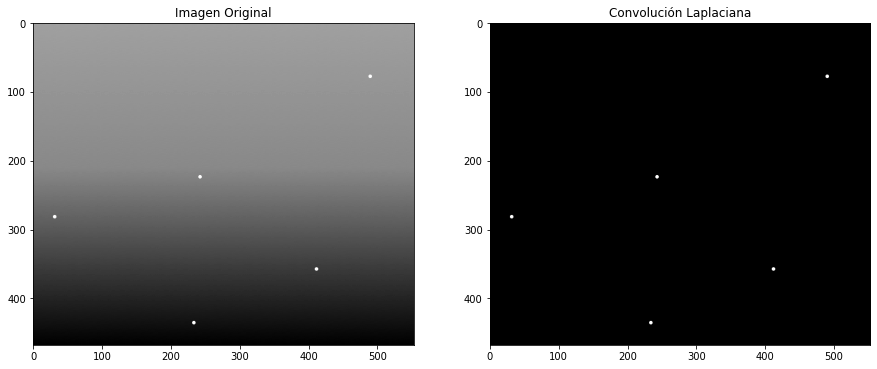

In [ ]:
#Se aplica la función trim para escalar los valores entre 0 y 255
laplace_filtered = img_trim(laplace_filtered, [0,255])

#Imprimir el máximo y el mínimo de la matriz para corroborar
print(np.min(laplace_filtered), np.max(laplace_filtered))

#Crear un subplot 1x2 para mostrar imagen de entrada y convolución Laplaciana
fig, ax = plt.subplots(1,2, figsize=(15, 8))
ax[0].set_title('Imagen Original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Convolución Laplaciana')
ax[1].imshow(laplace_filtered>128, cmap='gray')

### CONVOLUCIÓN PARA LA DETECCIÓN DE LINEAS

El siguiente nivel de complejidad es la Detección de Líneas. Las máscaras que se presentan a continuación extraen líneas de un píxel de ancho en una dirección particular:
<br>
<center><i>Figura. Mascaras de convolucion para la deteccion de lineas.</i></center>
<img src="res/M7/lines_detector.png\" alt="" style="height:250px">
<br>
Se obtiene una respuesta máxima cuando hay líneas de 1 píxel de grosor, la línea coincide con la dirección de los coeficientes mayores y el fondo es constante. En zonas homogéneas la respuesta de la mascara es cero.

#### IMPORTANTE: Para garantizar este comportamiento en las zonas homogéneas, es deseable que la sumatoria de todos los valores en la máscara sea 0.

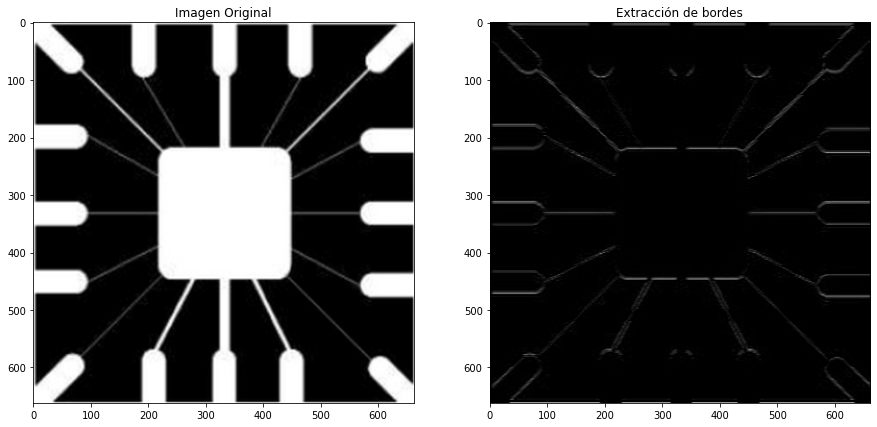

In [ ]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

#Leer imagen de entrada
img = img_read('./res/M7/lines.png', "grey").astype(np.float32)

#Generar una máscara para cada ejemplo de arriba.
mask1 = np.array([[-1,-1,-1],
                  [2,2,2],
                  [-1,-1,-1]], dtype=float)

mask2 = np.array([[-1,2,-1],
                  [-1,2,-1],
                  [-1,2,-1]], dtype=float)

mask3 = np.array([[2,-1,-1],
                  [-1,2,-1],
                  [-1,-1,2]], dtype=float)

mask4 = np.array([[-1,-1,2],
                  [-1,2,-1],
                  [2,-1,-1]], dtype=float)

#Ya que todos los filtros son lineales,  aplicar por separado y luego sumar
#las imágenes resultantes.

imgf1 = cv2.filter2D(img, ddepth = -1, kernel=mask1)
imgf2 = cv2.filter2D(img, ddepth = -1, kernel=mask2)
imgf3 = cv2.filter2D(img, ddepth = -1, kernel=mask3)
imgf4 = cv2.filter2D(img, ddepth = -1, kernel=mask4)

#Nota: pruebe distintas combinaciones de los valores.

#Sumar los filtros, aplicarle trim para escalar los valores
res = img_scale(imgf1+imgf2+imgf3+imgf4)
res = imgf1
res = img_trim(res)

#Generar subplot 1x2 y mostrar imagen original e imagen con extracción de bordes
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 8))
ax1.set_title('Imagen Original')
ax1.imshow(img, cmap='gray')
ax2.set_title('Extracción de bordes')
ax2.imshow(res, cmap='gray')


<hr>

##  2.3. LA DERIVADA Y SU RELACIÓN CON LOS BORDES
<br>
La Detección de Bordes se hace con base en las discontinuidades de los píxeles. Un borde es un conjunto de píxeles conectados que se encuentran en el límite entre dos regiones.
<br><br>
<center><i>Figura. Discontinuidades.</i></center>
<img src="res/M7/discontinuidades.png\" alt="" style="height:350px">
<br>
<center><i>Figura. Perfil de linea.</i></center>
<img src="res/M7/perfil_linea.png\" alt="" style="height:350px">
<br>

En el dominio espacial y discreto, la derivada se puede plantear como la diferencia entre valores consecutivos en una secuencia de datos que representan una dimension del espacio.
<br>
<center><i>Figura. Diferencias: primer orden y segundo orden.</i></center>
<img src="res/M7/diferencias.png\" alt="" style="width:800px">
<br>
La primera derivada es cero en todas las regiones de intensidad constante, y tiene un valor constante en toda la transición de intensidad.  La segunda derivada en cambio, es cero en todos los puntos, excepto en el comienzo y el final de una transición de intensidad.

Un cambio de intensidad se manifiesta como un cambio brusco en la primera derivada y un cambio de signo en la segunda derivada.

<br>
<center><i>Figura. Diferencias: primer orden y segundo orden.</i></center>
<img src="res/M7/diferencias_2.png\" alt="" style="width:700px">
<br>



El <font color='red'>gradiente</font> de una imagen f(x,y) en un punto (x,y) se define como un vector bidimensional perpendicular al borde, dado por:
<br>
<h2>$G[f(x,y)]=\begin{vmatrix} G_x \\ G_y \end{vmatrix} = \begin{vmatrix} \frac{\partial}{\partial_x} \\ \frac{\partial}{\partial_y} \end{vmatrix}$</h2>
<br>
Su magnitud y dirección se definen como:
<br>
<h2>$\left| G \right| = \sqrt{G_x^2 + G_y^2}$</h2>
<h2>$\alpha(x,y) = tan^-1{\frac{G_y}{G_x}}$</h2>
<br>
Las derivadas parciales $\partial_x$ y $\partial_y$, se definen como:
<br>
<h2>$\partial_x = \frac{f(x+\Delta x) - f(x)}{\Delta x}$</h2>
<h2>$\partial_y = \frac{f(y+\Delta y) - f(y)}{\Delta y}$</h2>
<br>

Ya que en el dominio discreto $\Delta x$ = 1.

Si f’(x) > 0, entonces la función es creciente en x
Si f’(x) < 0, entonces la función es decreciente en x
Si f’(x) = 0, entonces la función es estacionaria en x


Y en forma de kernel:

<h2>$\partial_x=\begin{bmatrix}
 0 & 0 & 0\\
 0 & -1 & 1\\
 0 & 0 & 0
\end{bmatrix}$</h2>


<h2>$\partial_y=\begin{bmatrix}
 0 & 0 & 0\\
 0 & -1 & 0\\
 0 & 1 & 0
\end{bmatrix}$</h2>

<center><i>Figura. Magnitud del gradiente.</i></center>
<img src="res/M7/gradiente.png\" alt="" style="height:400px">
<br>


## 3.4. OPERADORES BASADOS EN LA DERIVADA
<br>
Los operadores de extracción de bordes suelen clasificarse en:
<ul>
    <li>De primera derivada.</li>
    <li>De segunda derivada.</li>
</ul>
<br>
Estudiaremos algunos operadores ampliamente difundidos para implementar el concepto de derivada en un punto y que consideran una vecindad de dimensión 3x3.

### 3.4.1 OPERADORES BASADOS EN LA PRIMERA DERIVADA

En el dominio de las imágenes la Primera Derivada nos indica donde hay cambios en la imagen, así:
La derivada es cero en las zonas que la imagen tienen un nivel de gris constante
La derivada es distinta de cero en toda la zona que tiene cambios de tipo rampa o tipo escalón;

### Filtro Sobel
<br>
Los operadores de sobel son una extensión de las ecuaciones (4) y (5) para la implementación de los gradientes mediante convolución.  Estos vienen dados por unas máscaras de 3x3 de la siguiente forma:
<br><br>
Sea <h2>$Z=\begin{bmatrix}
 z_1 & z_2 & z_3\\
 z_4 & z_5 & z_6\\
 z_7 & z_8 & z_9
\end{bmatrix}$</h2>
<br>
Entonces,
<h2>$Sobel_x = \partial_𝑥=(z_3+2z6+𝑧_9)−(z_1+2z_4+z_7)$</h2>
<h2>$Sobel_y = \partial_y=(z_7+2z8+𝑧_9)−(z_1+2z_2+z_3)$</h2>
<br>
Que en forma de convolucion, estaria conformado por las siguientes mascaras:
<br>
<h2>$\partial_x=\begin{bmatrix}
 -1 & 0 & 1\\
 -2 & 0 & 2\\
 -1 & 0 & 1
\end{bmatrix}$</h2>
<h2>$\partial_y=\begin{bmatrix}
 -1 & -2 & -1\\
 0 & 0 & 0\\
 1 & 2 & 1
\end{bmatrix}$</h2>

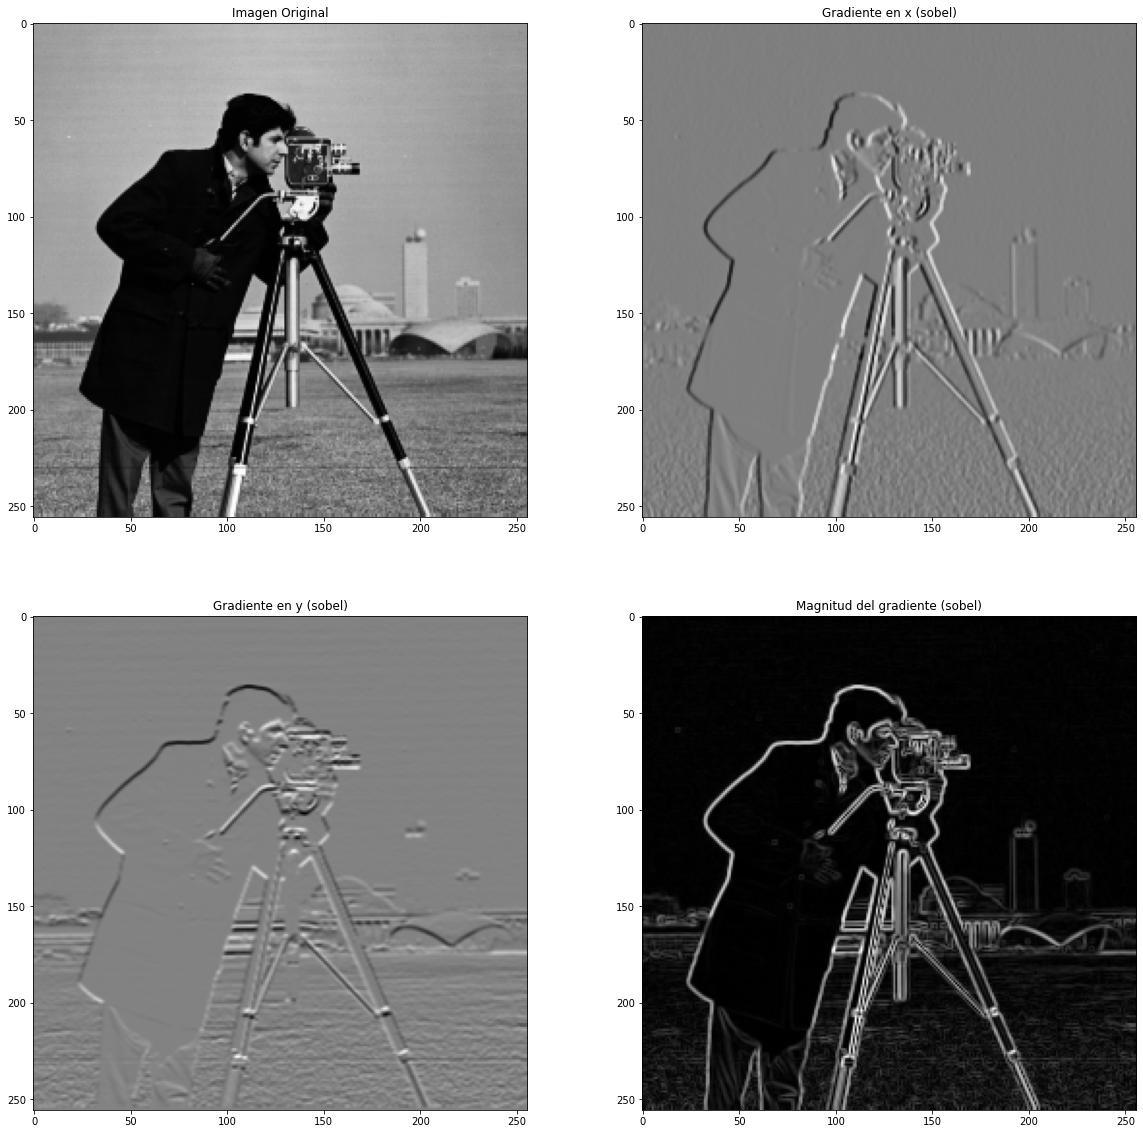

In [ ]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel_v,sobel_h, sobel
import skimage

#Leer imagen de entrada con tipo de dato float32
img = img_read('./res/camera.png', "gray").astype(np.float32)

#La función Sobel recibe: la imagen, el parámetro ddepth, el orden de la derivada que queremos calcular
#en x, el orden de la deirvada que queremos calcular en y,  el tamaño del kernel.
gradiente_x = cv2.Sobel(img, ddepth=-1, dx = 1, dy = 0, ksize = 3)
gradiente_y = cv2.Sobel(img, ddepth=-1, dx = 0, dy = 1, ksize = 3)

#Calcula la magnitud del sobel, por definición
magnitud_sobel = np.sqrt(np.power(gradiente_x,2)+np.power(gradiente_y,2))

#Realizar el escalamiento de la imagen
magnitud_sobel = img_scale(magnitud_sobel)

#Generar subplot 2x2 para mostrar la imagen original, sus gradientes x e y & la magnitud
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,0].set_title('Imagen Original')
ax[0,0].imshow(img, cmap='gray')
ax[0,1].set_title('Gradiente en x (sobel)')
ax[0,1].imshow(gradiente_x, cmap='gray')
ax[1,0].set_title('Gradiente en y (sobel)')
ax[1,0].imshow(gradiente_y, cmap='gray')
ax[1,1].set_title('Magnitud del gradiente (sobel)')
ax[1,1].imshow(magnitud_sobel, cmap='gray')

### Filtro Prewitt
<br>
Definido mediante las siguientes mascaras de convolución:
<br>
<h2>$\partial_x=\begin{bmatrix}
 -1 & 0 & 1\\
 -1 & 0 & 1\\
 -1 & 0 & 1
\end{bmatrix}$</h2>
<h2>$\partial_y=\begin{bmatrix}
 -1 & -1 & -1\\
 0 & 0 & 0\\
 1 & 1 & 1
\end{bmatrix}$</h2>

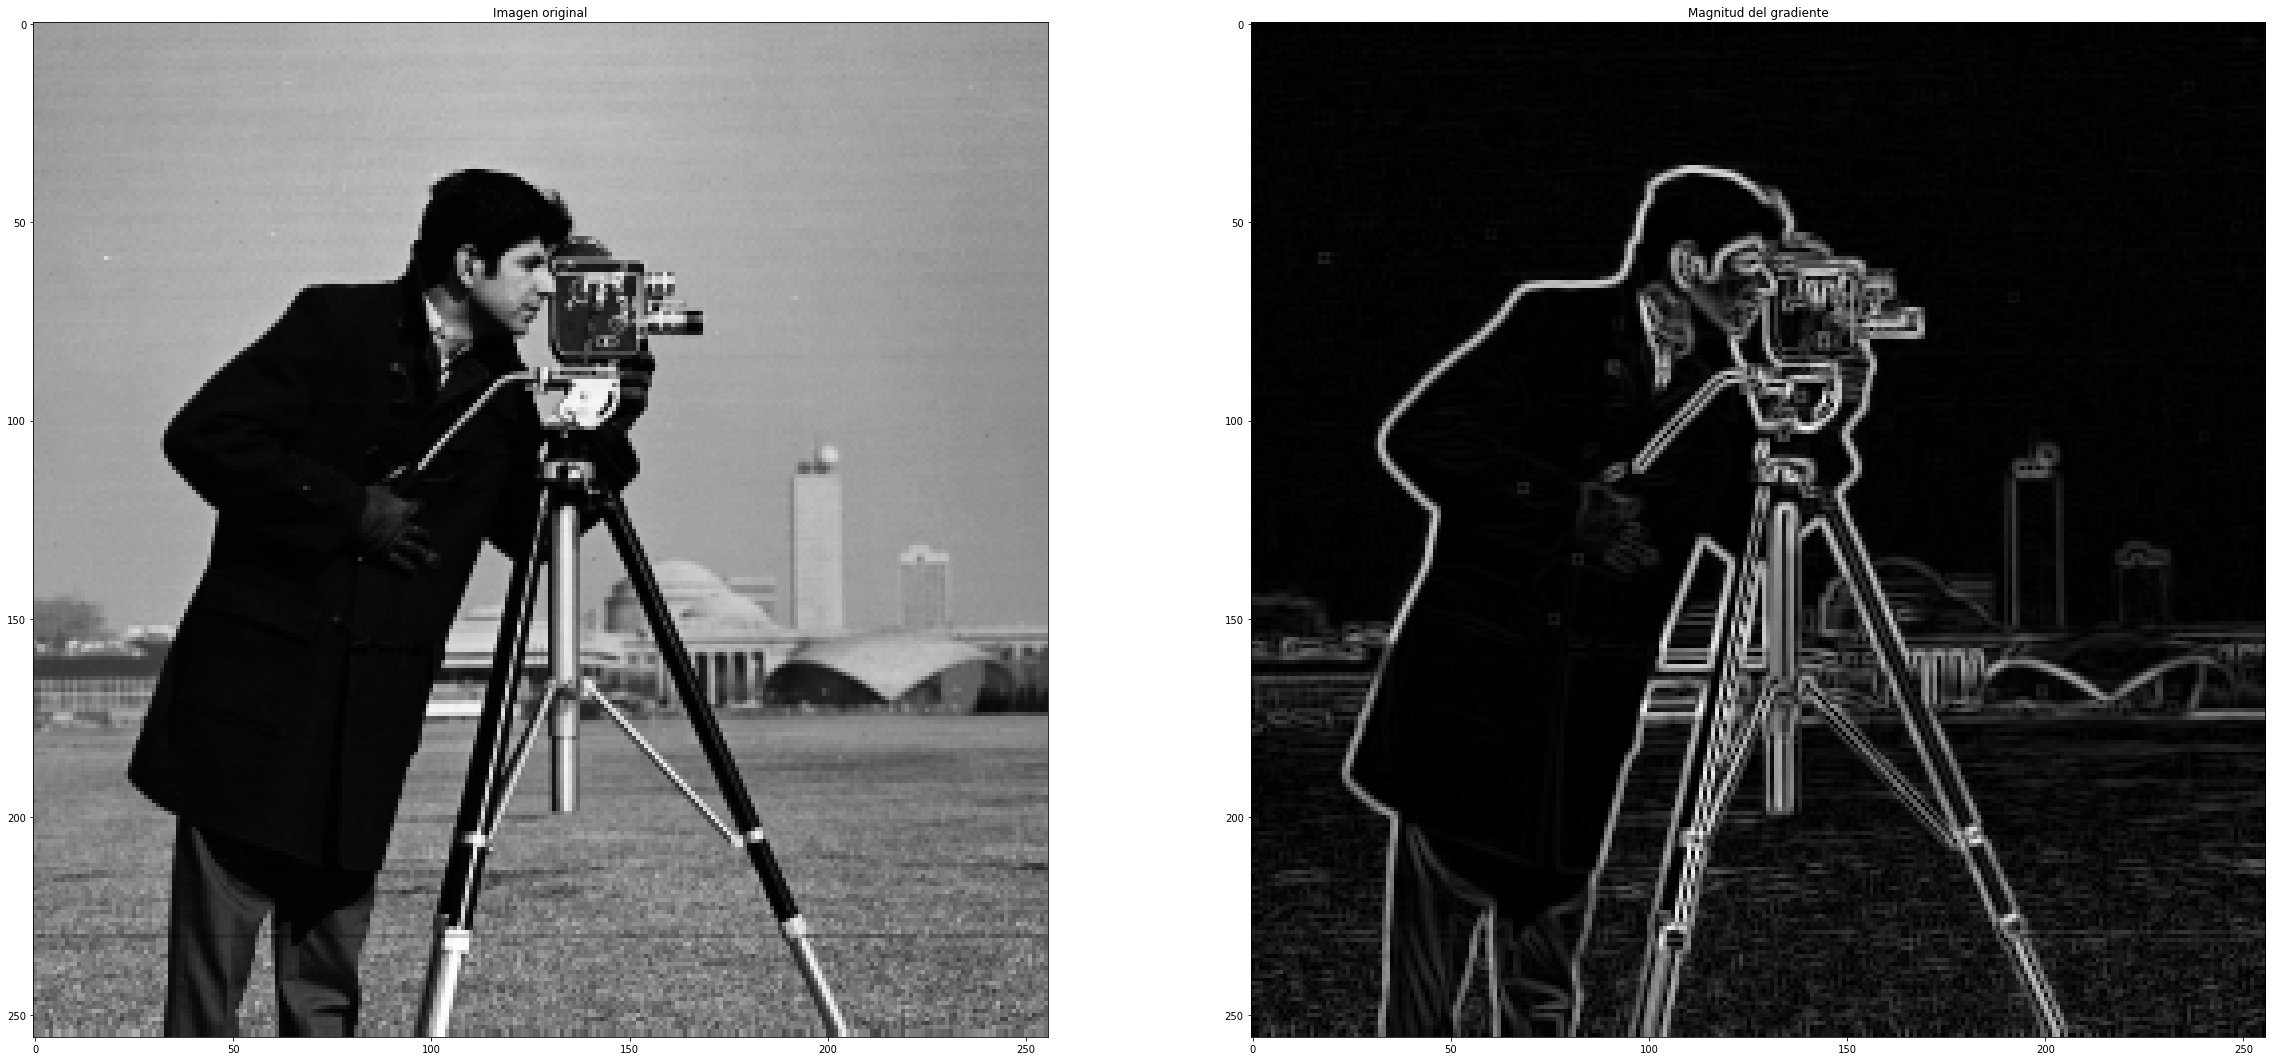

In [ ]:
#Importar librerías

import numpy as np
import matplotlib.pyplot as plt
import cv2

#Crear las máscaras del filtro Prewitt
prewitt_x=np.array([[-1,0,1],
                   [-1,0,1],
                   [-1,0,1]],dtype=int)


prewitt_y=np.array([[-1,-1,-1],
                   [0,0,0],
                   [1,1,1]],dtype=int)


#Leer la imagen de entrada y convolucionarla con los dos filtros Prewitt
img = img_read('./res/camera.png', "gray").astype(np.float32)
imgc1 = cv2.filter2D(img, ddepth=-1, kernel=prewitt_x)
imgc2 = cv2.filter2D(img, ddepth=-1, kernel= prewitt_y)

#Calcular la magnitud
magnitud_prewitt = np.sqrt(np.power(imgc1,2)+np.power(imgc2,2))

#Escalar los datos
magnitud_prewitt = img_scale(magnitud_prewitt)

#Generar un subplot 1x2 para mostrar imagen original y la magnitud del gradiente Prewitt
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(40, 40))
ax1.set_title('Imagen original')
ax1.imshow(img, cmap='gray')
ax2.set_title('Magnitud del gradiente')
ax2.imshow((magnitud_prewitt), cmap='gray')

### Analicemos:
<ul>
    <li>¿Qué diferencias encuentra entre el filtro de Sobel y el de Prewitt?</li>
</ul>
<hr>

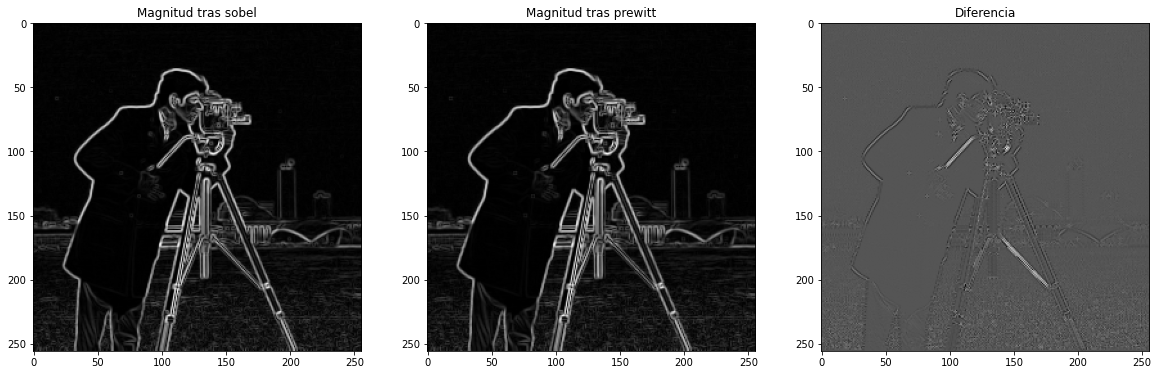

In [ ]:
#Restar las magnitudes de los filtros Sobel y Prewitt
diferencia = magnitud_sobel-magnitud_prewitt

#Generar subplot 1x2 para mostrar las magnitudes y su diferencia
fig, ax = plt.subplots(1,3, figsize=(20, 30))
ax[0].set_title('Magnitud tras sobel')
ax[0].imshow(magnitud_sobel, cmap='gray')
ax[1].set_title('Magnitud tras prewitt')
ax[1].imshow(magnitud_prewitt, cmap='gray')
ax[2].set_title('Diferencia')
ax[2].imshow(diferencia, cmap='gray')

### Filtro Frei-Chen
<h2>$\partial_x=\begin{bmatrix}
 -1 & 0 & 1\\
 -\sqrt{2} & 0 & \sqrt{2}\\
 -1 & 0 & 1
\end{bmatrix}$</h2>
<h2>$\partial_y=\begin{bmatrix}
 -1 & -\sqrt{2} & -1\\
 0 & 0 & 0\\
 1 & \sqrt{2} & 1
\end{bmatrix}$</h2>
<br>

### Filtro Scharr
<h2>$\partial_x=\begin{bmatrix}
 -3 & 0 & 3\\
 -10 & 0 & 10\\
 -3 & 0 & 3
\end{bmatrix}$</h2>
<h2>$\partial_y=\begin{bmatrix}
 -3 & -10 & -3\\
 0 & 0 & 0\\
 3 & 10 & 3
\end{bmatrix}$</h2>
<br>
<center><i>Figura. Comparacion entre distintos filtros.</i></center>
<img src="res/M7/comparacion.png\" alt="" style="width:800px">
<hr>


### 3.4.2 OPERADORES BASADOS EN LA SEGUNDA DERIVADA
<br>
En el dominio de las imágenes la Segunda Derivada nos indica donde hay cambios en la imagen, así:
- Es distinta de cero al principio o al final de un cambio tipo escalón o rampa
- Es cero en la zona que tiene un cambio tipo rampa con pendiente constante
- Es cero en zonas con nivel de gris constante

Los mínimos y máximos de una función diferenciable f(x) están definidos por su Segunda Derivada:

- Si f’’(x) > 0, entonces la función tiene un mínimo relativo en X
- Si f’’(x) < 0, entonces la función tiene un máximo relativo en X
- Si f’’(x) = 0, entonces hay cambio de concavidad


En nuestro caso discreto, la segunda derivada se puede aproximar por:

![image.png](attachment:image.png)

En este caso tenemos los filtros, Laplaciana y Laplaciana de la Gaussiana.
<br>
### Filtro de la Laplaciana
Se define como:
<h2>$\nabla^2f(x,y)=\frac{\partial^2f}{\partial_x^2}+\frac{\partial^2f}{\partial_y^2}$</h2>
<br>
Si observamosla ecuacion anterior, ahora no tenemos dos gradientes, por lo cual estos operadores pueden ser implementados mediante <font color='red'>una única convolución</font>. Este se puede implementar de forma digital de distintas maneras:
<br>
<h2>$\nabla^2f=f*\begin{bmatrix}
 0 & -1 & 0\\
 -1 & 0 & -1\\
 3 & -1 & 3
\end{bmatrix}$</h2>
<h2>$\nabla^2f=f*\begin{bmatrix}
 1 & -2 & 1\\
 -2 & 4 & -2\\
 1 & -2 & 1
\end{bmatrix}$</h2>
<h2>$\nabla^2f=f*\begin{bmatrix}
 -1 & -1 & -1\\
 -1 & 8 & -1\\
 -1 & -1 & -1
\end{bmatrix}$</h2>
<br>
Donde el operador $*$ representa una convolucion.
<br>

Puesto que el Laplaciano es un operador de derivación de segundo orden, la suma de los coeficientes debe ser cero. Además, el coeficiente asociado con el píxel central debe ser positivo y todos los demás coeficientes negativos o cero, o viceversa.

<center><i>Figura. Filtro Laplaciana.</i></center>
<img src="res/M7/laplaciana2.png\" alt="" style="width:700px">
<br>

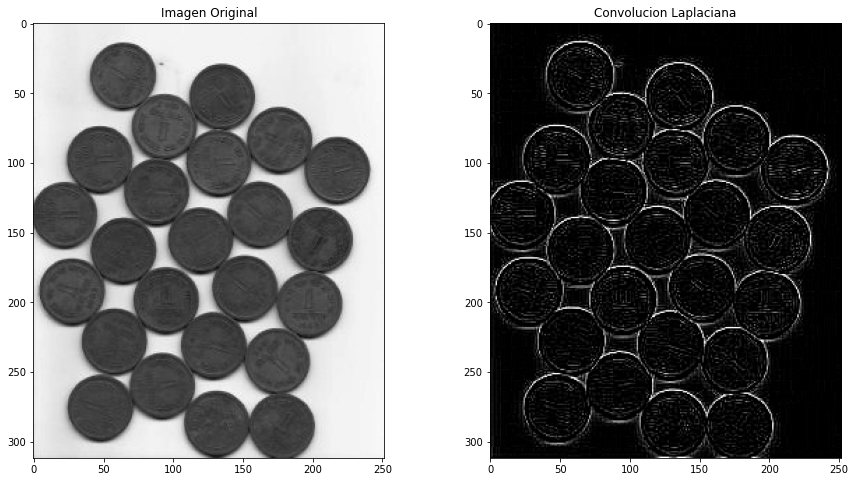

In [ ]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#Leer imagen de entrada
img = img_read('./res/water_coins.jpg', "gray")

#Crear la máscara de convolución
mask1 = np.array([[-1,-1,-1],
                 [-1,8,-1],
                 [-1,-1,-1]])

#Realizar la convolución
laplace_filtered = cv2.filter2D(img, ddepth = -1, kernel=mask1)

#Generar subplot 1x2 para mostrar imagen original y convolución Laplaciana
fig, ax = plt.subplots(1,2, figsize=(15, 8))
ax[0].set_title('Imagen Original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Convolucion Laplaciana')
ax[1].imshow(laplace_filtered, cmap='gray')

### Filtro Laplaciana de la Gaussiana
<br>
Debido a que los kernels anteriores son aproximaciones de la segunda derivada de la imagen, son muy sensibles al ruido.  Para contrarestar esto, la imagen es suavizada por un Gaussiano antes de aplicar el filtro Laplaciano.  Este preprocesamiento reduce los componentes del ruido de alta frecuencia.

Debido a que la operación de convolución es asociativa, podemos convolucionar el filtro Gaussiano y el Laplaciano y luego convolucionar la imagen con este filtro híbrido y obtener el resultado deseado:
<br>
<h2>$LG(x,y) = {\frac{1}{\pi\sigma^4}}\left[ 2 - \frac{x^2+y^2}{\sigma^2} \right]e^{-{\frac{x^2+y^2}{2\sigma^2}}}$</h2>
<br>
<ul>
    <li>Es un operador de segunda derivada, que reduce el efecto del ruido al suavizar la imagen por el efecto Gaussiano.</li>
    <li>Es un operador isotropo capaz de detectar bordes en todas las direcciones.</li>
    <li>Es un operador capaz de trabajar a diferentes escalas con la simple variación de la desviación estándar (sigma).</li>
    <li>La dimensión del operador dado, se representa por el ancho de la porción positiva central w, y está relacionado con sigma.</li>
    <li>Cuanto mayor es el valor de sigma, más estrecho es el ancho de banda del filtro, es decir, se detectarán los bordes más marcados.</li>
</ul>

Text(0.5, 0, 'z')

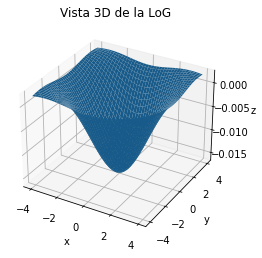

In [ ]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

#Definir los valores sigma, N, y la matriz para generar la Gaussiana
sigma = 2.5
N = 4
LG = np.zeros([N,N])

#Función LG(x,y) mostrada en el ejemplo
def LoG(x,y,sigma):
    LG = -((1)/(math.pi*sigma**4))*(2-((x**2+y**2)/(sigma**2)))*np.exp(-((x**2+y**2)/(2*sigma**2)))
    return LG

#Crear la figura para mostrar en 3-D la función LoG
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Vista 3D de la LoG')

#Crear los dominos de x e y
x = y = np.arange(-N, N, 0.05)
#Crear una malla cuadrada con los valores igualmente espaciados de x e y
X, Y = np.meshgrid(x, y)

#Aplicar la función LoG sobre cada uno de los puntos de la malla
zs = np.array([LoG(i,j,sigma) for i,j in zip(np.ravel(X), np.ravel(Y))])

#Asegurarse que la salida tenga el mismo tamaño que las entradas
Z = zs.reshape(X.shape)

#Mostrar la función
ax.plot_surface(X, Y, Z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

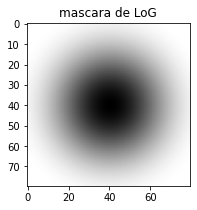

In [ ]:
#Generar una figura para mostrar la máscara en 2 dimensiones
fig2, ax = plt.subplots(1,1, figsize=(3, 3))

#Definir dominio de x e y, aplicar la función LoG sobre cada x e y
x = y = np.arange(-N, N, 0.1)
mask = np.array([[LoG(i,j,sigma) for i in np.ravel(x)] for j in np.ravel(x)])

#Mostrar la máscara de LoG
ax.set_title('mascara de LoG')
ax.imshow(mask,cmap='gray')

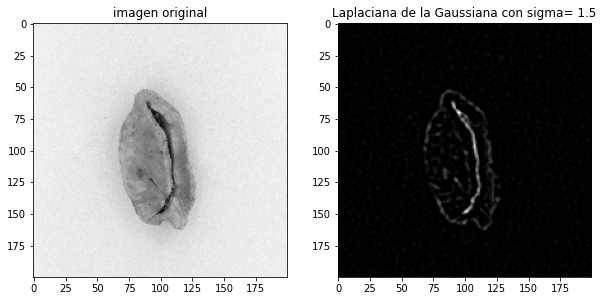

In [ ]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

#Leer imagen de entrada, darle tamaño 400x400 y recortarla entre 100 y 300
img = img_read('./res/cafe.JPG', "gray").astype(np.float32)
img = cv2.resize(img, (400,400))
img = img[100:300,100:300]

#Definir sigma y el tamaño del kernel
sigma = 1.5
k_size = 5

#Aplicar un filtro Gaussiano y un Laplaciano sobre la Gaussiana
res =  cv2.GaussianBlur(img, (k_size,k_size), sigma)
res = cv2.Laplacian(res, ddepth = -1, ksize= 3)
#Escalar los valores menores a 0 y mayores que 255
res = img_trim(res)

#Generar un subplot para mostrar imagen original y la Laplaciana de la Gaussiana
fig2, ax = plt.subplots(1,2, figsize=(10, 7))
ax[0].set_title('imagen original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Laplaciana de la Gaussiana con sigma= '+str(sigma))
ax[1].imshow(res, cmap='gray')

Observaciones sobre las derivadas:
- Las derivadas de primer orden, generalmente producen bordes gruesos en una imagen.

- Las derivadas de segundo orden tienen una respuesta mayor a detalles finos, como líneas delgadas y puntos aislados.

- Las derivadas de primer orden tienen una respuesta mayos a funciones escalón de nivel de gris.

- Las derivadas de segundo orden producen una doble respuesta en cambios de tipo escalón.


# 3.5. OPERADORES AVANZADOS

### Filtro de Canny
El Detector de Bordes Canny es un algoritmo se fundamenta en la teoría de los operadores de primera derivada y resulta particularmente interesante porque extrae bordes y cierra los contornos evitando las rupturas de los bordes durante su extracción.

Este detector de bordes tiene en cuenta ciertas condiciones
<ul>
    <li><b>Error</b>: Se deben detectar todos y sólo los bordes.</li>
    <li><b>Localización</b>: La distancia entre el píxel señalado como borde y del borde real debe ser tan pequeña como se pueda.</li>
    <li><b>Respuesta</b>: No se deben identificar varios píxeles como bordes cuando sólo exista uno.</li>
</ul>
<br>
El algoritmo del Detector de Bordes Canny básicamente consta de tres pasos:
<ul>
    <li><b>Paso 1</b>:Obtención del gradiente (magnitud y ángulo de cada píxel) de la imagen suavizada.</li>
    <li><b>Paso 2</b>:Adelgazamiento del ancho de los bordes obtenidos con el gradiente, hasta lograr bordes de un píxel de ancho, se conoce como “supresión no máxima”.</li>
    <li><b>Paso 3</b>:Histéresis de umbral al resultado de la supresión no máxima con la que se pretende reducir la posibilidad de aparición de contornos  falsos.</li>
</ul>

### Paso 1: Magnitud y Orientacion
<br>
<center><i>Figura. Primer paso: Orientacion - Filtro de Canny.</i></center>
<img src="res/M7/canny_primer_paso.png\" alt="" style="width:700px">
<br>
<center><i>Figura. Primer paso: Orientacion y Magnitud - Filtro de Canny.</i></center>
<img src="res/M7/canny_primer_paso2.png\" alt="" style="width:700px">

### Paso 2: Supresion de No-Maximos

El objetivo es obtener bordes de 1 px de grosor al considerar únicamente px cuya magnitud es máxima en bordes gruesos y descartar aquellos cuyas magnitudes no alcancen ese máximo.

El resultado de la etapa anterior son dos imágenes una de la magnitud del gradiente ($E_m$) y una con la dirección del gradiente ($E_a$).

La supresión no máxima se realiza de la siguiente manera:
<ul>
    <li>Para todo punto $(x, y)$ se obtiene la dirección más cercana a 0°, 45°, 90° y 135°a partir de la imagen $E_a$ a la que denotamos $d_k$.</li>
<br>
    <li>$E_m(x,y)$ es menor que uno de sus dos vecinos en la dirección $d_k$ entonces al píxel $(x,y)$ de la nueva imagen $I_N$ se le asigna el valor 0 (supresión) de otro modo $I_N(x,y) = E_m(x,y)$</li>
</ul>
<br>
<center><i>Figura. Supresion no maximos.</i></center>
<img src="res/M7/supresion.png\" alt="" style="width:700px">
<br>
<center><i>Figura. Ejemplo de supresion no maximos.</i></center>
<img src="res/M7/ejemplo_supresion.png\" alt="" style="width:800px">

<h3>Paso3: Histeresis</h3>
<br><br>
Con este paso se busca eliminar los máximos que son provenientes de ruido. Se toma como entrada la imagen $I_N$, (la salida del paso anterior) y la imagen $E_a$ (la orientación de los bordes) y dos umbrales $t_1$ y $t_2$, tal que $t_1 < t_2$.

Recorriendo la imagen $I_N$ en un orden establecido:
<ul>
    <li>Localice el siguiente punto de borde no explorado previamente tal que $I_N(x, y) > t_2$</li>
    <br>
    <li>Comience a partir del punto $I_N(x,y)$, siga todas las cadenas de máximos locales conectados en ambas direcciones perpendiculares a la normal del borde, siempre que $I_N > t_1$. Marque todos los puntos explorados y guarde todos los puntos del contorno que se encontraron.</li>
</ul>

La salida es un conjunto de bordes conectados de contornos de la imagen, así como la magnitud y la orientación.
<br>
<center><i>Figura. Histeresis.</i></center>
<img src="res/M7/histeresis.png\" alt="" style="width:800px">
<br>
<center><i>Figura. Canny completo.</i></center>
<img src="res/M7/canny_complete.png\" alt="" style="width:900px">
<br>
<center><i>Figura. Canny Ejemplo.</i></center>
<img src="res/M7/canny_ejemplo_2.png\" alt="" style="width:900px">
<br>
<center><i>Figura. Canny valores de sigma.</i></center>
<img src="res/M7/canny_sigma.png\" alt="" style="width:900px">

A continuación la implementación del algoritmo Canny:

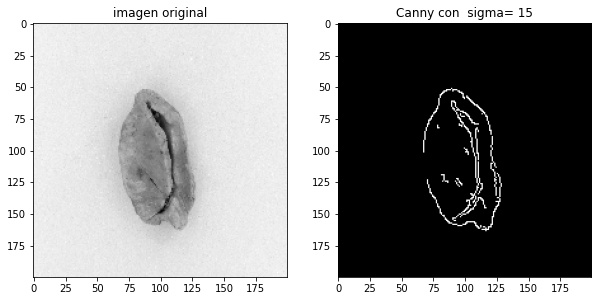

In [ ]:
#Importar librerías
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from skimage import data

#Leer imagen de entrada, darle tamaño 400x400 y recortarla entre 100 y 300
img = img_read('./res/cafe.JPG', "gray")
img = cv2.resize(img, (400,400))
img = img[100:300,100:300].astype(np.uint8)

#Definir el sigma
sigma = 15

#Suavizamos la imagen para eliminar ruido (aplicar filtro Gaussiano)
result = cv2.GaussianBlur(img, (3,3), sigma)

#Aplicar el filtro de Canny como función de cv2 y darle límite entre 0 y 255
result = cv2.Canny(img, threshold1= 100, threshold2 = 180)

#Generar un subplot 1x2 que muestre imagen original y Canny
fig2, ax = plt.subplots(1,2, figsize=(10, 7))
ax[0].set_title('imagen original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Canny con  sigma= '+str(sigma))
ax[1].imshow(result, cmap='gray')

### Transformada de Hough para líneas

La Transformada Hough permite encontrar ciertas formas dentro de una imagen, como líneas y círculos. La versión más simple consiste en encontrar líneas.

Funcionamiento … suponga que estamos buscando líneas rectas en una imagen.

Si tomamos una línea en la imagen, todos los puntos que pasan a través de esa línea tienen la forma:

𝑦 = 𝑚𝑥 +𝑏

Donde x e y son variables, m y b son contantes.

<center><i>Figura. Transformada de Hough.</i></center>
<img src="res/Hough1.png\" alt="" style="width:700px">

Por otro lado, si asumimos que la pendiente y el desplazamiento son constantes, entonces un punto en el dominio de la imagen correspondería a una línea en el dominio de los parámetros, es decir el mismo punto puede pertenecer a diferentes líneas con pendientes y desplazamientos distintos:

𝑦′ = 𝑚𝑥′ +𝑏

Donde x’ e y’ son constantes, m y b son las variables.


<center><i>Figura. Transformada de Hough.</i></center>
<img src="res/Hough1.png\" alt="" style="width:700px">


Por la limitación del espacio de Hough, se usa una representación POLAR del mismo:

<center><i>Figura. Transformada de Hough.</i></center>
<img src="res/Hough2.png\" alt="" style="width:700px">

Para todos los puntos que pertenecen a una línea, Las curvas que los representan se intersectan en un mismo punto en el espacio de Hough.

<center><i>Figura. Transformada de Hough.</i></center>
<img src="res/Hough3.png\" alt="" style="width:700px">

<center><i>Figura. Transformada de Hough.</i></center>
<img src="res/Hough4.png\" alt="" style="width:800px">

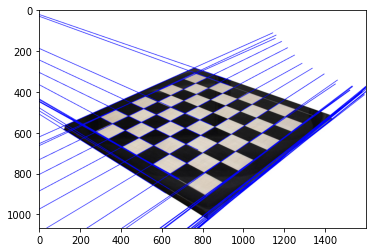

In [ ]:
#Importar librerías
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada
img = img_read('res/ajedrez001.jpg')

#Aplicar filtro Canny para encontrar los bordes
edges = cv2.Canny(img,50,150)

#Utilizar la transformada de Hough (implementación en cv2)
#Encontrar las líneas de una imagen, los parámetros de entrada son:
#imagen binaria, ro (en píxeles) y theta (en radianes)
lines = cv2.HoughLines(edges,1,np.pi/180,200)
for line in lines:
    #Obtener los valores rho, theta de la primera fila de la matriz
    rho,theta = line[0]
    #Aplicarle seno y coseno a theta y multiplicarlos por rho
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    #Encontrar los dos puntos necesarios para formar una línea recta
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    #Mostrar la imagen
plt.imshow(img,cmap='gray')

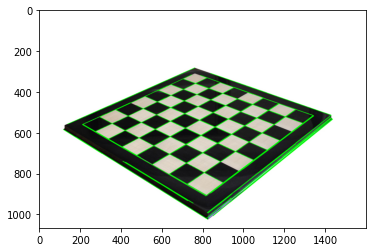

In [ ]:
#Implementación de otra versión (probabilistica) de la transformada de Hough para lineas.

#Importar librerías
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada
img = img_read('res/ajedrez001.jpg','color')

#Aplicar filtro Canny
edges = cv2.Canny(img,50,150)

#Aplicar la transformada probabilistica de Hough y hallar los puntos x1,y1,x2,y2
#por los que pasa la línea recta
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

#Mostrar la imagen
plt.imshow(img,cmap='gray')

### Transformada de Hough para Circulos

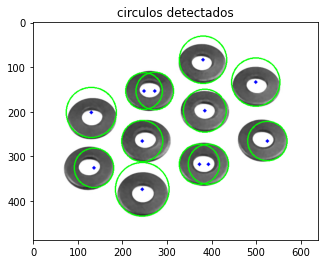

In [ ]:
#Importar librerías
import numpy as np
import cv2
from matplotlib import pyplot as plt

#Leer la imagen de entrada y aplicarle un filtro de mediana
img = img_read('res/arandelas003.jpg','gray')
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

#Aplicar la Transformada de Hough para círculos
#https://docs.opencv.org/3.4.2/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=70,minRadius=0,maxRadius=0)

#Redondear y convertir a tipo de dato uint16
circles = np.uint16(np.around(circles))

#Dibujar los círculos recorriendo cada posición i del vector circles(0,:)
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

    #Dibujar la imagen original y los círculos detectados
plt.title('circulos detectados')
plt.imshow(cimg)

# 4. SEGMENTACIÓN

La segmentación es la partición de una imagen en regiones homogéneas con respecto a una o más características, p. ej.:

- La forma
- El color
- El brillo
- La textura

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg1.png\" alt="" style="width:800px">

El nivel de la subdivisión de una imagen depende del problema, por ejemplo, hasta que los objetos de interés buscados hayan sido aislados.

- Segmentación completa: termina cuando los objetos que aparecen en una imagen se corresponden unívocamente con las distintas regiones.

- Segmentación parcial: se crean agrupaciones de objetos.

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg2.png\" alt="" style="width:800px">

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg3.png\" alt="" style="width:800px">

El uso del conocimiento sobre la imagen (o de un modelo de ella) reduce la complejidad de la segmentación: color, forma, tamaño que ocupa el objeto a segmentar en la imagen, etc…

Las regiones a segmentar deben tener una fuerte correlación con los objetos del “mundo real”.

En aplicaciones industriales es posible controlar las condiciones de captura de las imágenes (iluminación, etc…) para facilitar la segmentación.

Cuando sea posible se puede usar un sensor que realce los objetos de interés y elimine detalles irrelevantes, p.e.: Cámaras de infrarrojos usadas en el ejército para detectar tropas en movimiento.


La segmentación puede verse como un proceso que a partir de una imagen produce otra imagen en la que cada píxel tiene asociada una etiqueta distintiva del objeto (región) a la que pertenece, por ejemplo:

- Detección de ciertos tipos de células en imágenes médicas,
- Extracción de los vehículos de una imagen de una carretera,
- Separación de los objetos de un fondo uniforme en una imagen.

Básicamente la segmentación se hace con base en:

- Similitud: se buscan regiones similares según cierto criterio. Ej.: umbralización del histograma, extracción de regiones (crecimiento de regiones, separación y unión de regiones), basada en movimiento, usando el color, usando texturas, etc.

- Discontinuidad: se buscan diferencias en la intensidad, Ej.: extracción de bordes.


<center><i>Figura. Segmentación.</i></center>
<img src="res/sg4.png\" alt="" style="width:800px">

## 4.1 SEGMENTACIÓN POR UMBRALIZACIÓN

La Umbralización permite convertir una imagen de niveles de gris en una imagen  binaria. La segmentación por umbralización (o thresholding) es una técnica que asume que hay un solo objeto (o varios objetos con las mismas características) sobre un fondo uniforme. Por esto se consideran dos regiones:

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg5.png\" alt="" style="width:800px">

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg6.png\" alt="" style="width:800px">

La solución yace en hallar el punto del histograma (valle) que mejor separe las regiones.

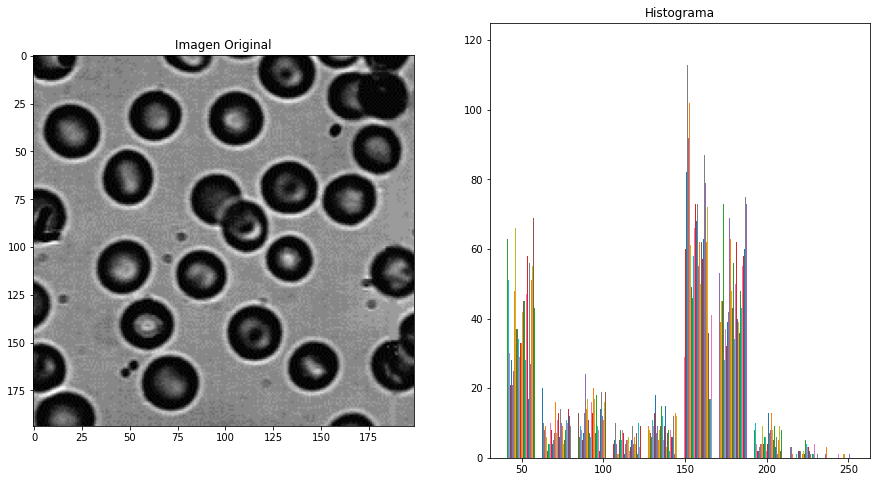

In [ ]:
#Importar librerías
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer la imagen de entrada con tipo de dato uint8
img = img_read('res/dots.png',"gray").astype(np.uint8)

#Generar subplot 1x2  que muestre imagen e histograma
fig, ax = plt.subplots(1,2, figsize=(15, 8))
ax[0].set_title('Imagen Original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Histograma')
ax[1].hist(img);

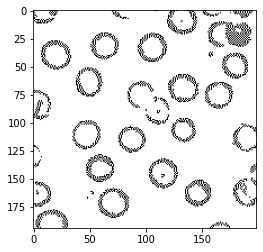

In [ ]:
#Tomar solamente los valores de la imagen mayores a 40
thresholded = img > 40
#Mostrar la nueva imagen
plt.imshow(thresholded, cmap="gray")

In [ ]:
thresholded

array([[False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

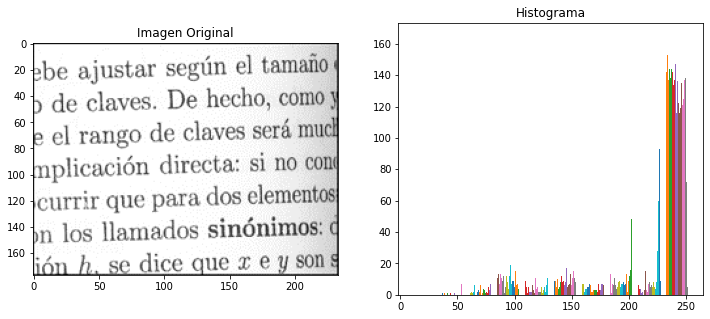

In [ ]:
#Importar librerías
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada
img = img_read('res/texto.png',"gray").astype(np.uint8)

#Generar subplot 1x2 para mostrar imagen de entrada e histograma
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].set_title('Imagen Original')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Histograma')
ax[1].hist(img);

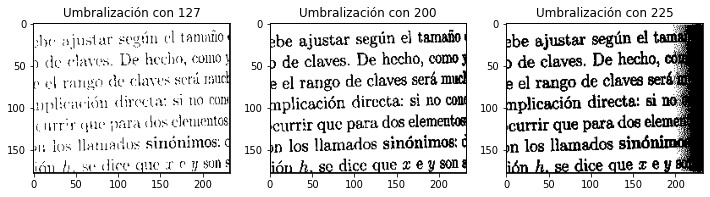

In [ ]:
#Realizar disintos threshold a la imagen a partir de distintos valores mínimos
thresholded1 = img > 127
thresholded2 = img > 200
thresholded3 = img > 225

#Generar un subplot 1x3 para mostrar las umbralizaciones y compararlas
fig, ax = plt.subplots(1,3, figsize=(12, 8))
ax[0].set_title('Umbralización con 127')
ax[0].imshow(thresholded1, cmap="gray");
ax[1].set_title('Umbralización con 200')
ax[1].imshow(thresholded2, cmap="gray");
ax[2].set_title('Umbralización con 225')
ax[2].imshow(thresholded3, cmap="gray");


OpenCV implementa la función threshold, que recibe como parametros la imagen, el valor del histograma, el valor que se le va a asignar a los píxeles que superen el umbral y un tipo de umbralización.

<center><i>Figura. Segmentación.</i></center>
<img src="res/seg7.png\" alt="" style="width:800px">

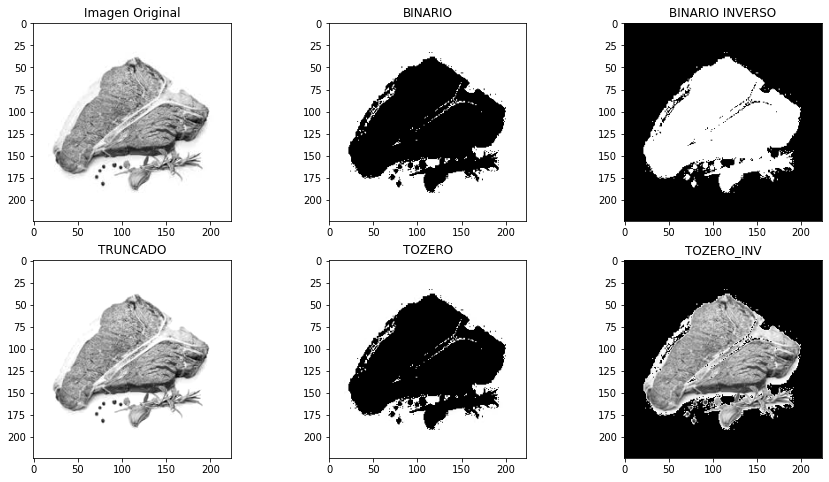

In [ ]:
#Importar librerías
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada
img = img_read('res/meat.jpg',"gray").astype(np.uint8)

#Definir un valor mínimo
val = 245

#Generar mediante la función threshold de cv2, las distintas aproximaciones que
#se ofrecen en la figura anterior
ret,thresh1 = cv2.threshold(img,val,145,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,val,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,val,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,val,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,val,255,cv2.THRESH_TOZERO_INV)

#Dar título a las imágenes y hacer una lista de éstas
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

#Generar un subplot 2x3 que muestre todas las umbralizaciones y la imagen original
fig, ax = plt.subplots(2,3, figsize=(15, 8))
ax[0][0].set_title('Imagen Original')
ax[0][0].imshow(img, cmap='gray')
ax[0][1].set_title('BINARIO')
ax[0][1].imshow(thresh1, cmap='gray')
ax[0][2].set_title('BINARIO INVERSO')
ax[0][2].imshow(thresh2, cmap='gray')
ax[1][0].set_title('TRUNCADO')
ax[1][0].imshow(thresh3, cmap='gray')
ax[1][1].set_title('TOZERO')
ax[1][1].imshow(thresh4, cmap='gray')
ax[1][2].set_title('TOZERO_INV')
ax[1][2].imshow(thresh5, cmap='gray')



In [ ]:
np.max(thresh1)

145

Para imágenes a color, a veces es necesario hacer un análisis de los espacios de color para obtener un umbral. Por ejemplo:



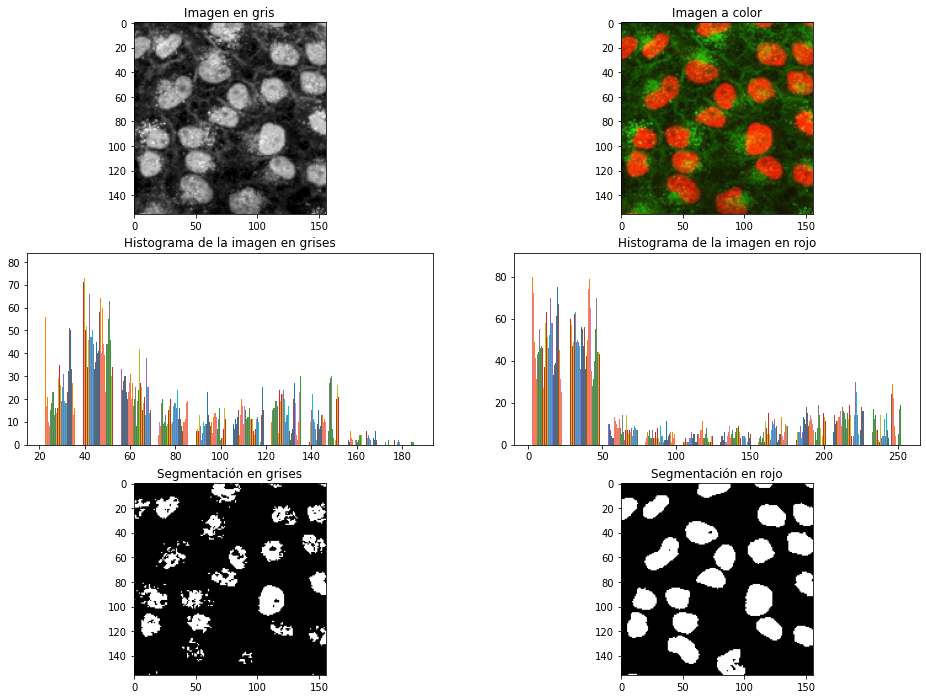

In [ ]:
#Importar librerías
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada en escala de grises y a color
img = img_read('res/cells.png',"gray").astype(np.uint8)
img_color = img_read('res/cells.png',"color").astype(np.uint8)

#Tomar el canal rojo del RGB
red = img_color[:,:,0]

#Umbrazizar las imágenes en gris y en el canal rojo
thresh_gray = img > 128
thresh_red = red > 128

#Generar un subplot 3x2 que muestre las umbralizaciones y sus histogramas
fig, ax = plt.subplots(3,2, figsize=(16, 12))


ax[0][0].set_title('Imagen en gris')
ax[0][0].imshow(img, cmap='gray')
ax[0][1].set_title('Imagen a color')
ax[0][1].imshow(img_color, cmap='gray')
ax[1][0].set_title('Histograma de la imagen en grises')
ax[1][0].hist(img)
ax[1][1].set_title('Histograma de la imagen en rojo')
ax[1][1].hist(red);


ax[2][0].set_title('Segmentación en grises')
ax[2][0].imshow(thresh_gray, cmap='gray')
ax[2][1].set_title('Segmentación en rojo')
ax[2][1].imshow(thresh_red, cmap='gray')

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg8.png\" alt="" style="width:800px">

## 4.2 SEGMENTACIÓN POR MULTI-UMBRALIZACIÓN

Hay casos donde la umbralización simple no es la solución, sobre todo cuando el histograma es multimodal:

<center><i>Figura. Segmentación por multi-umbralización.</i></center>
<img src="res/sg9.png\" alt="" style="width:800px">

La Multi-Umbralización consiste en la elección de múltiples valores de umbral, permitiendo separar a diferentes objetos dentro de una escena cuyos niveles de gris difieran. Ejemplo:

<center><i>Figura. Segmentación por multi-umbralización.</i></center>
<img src="res/sg10.png\" alt="" style="width:800px">

In [1]:
#Importar librerías
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada con tipo de dato uint8
img = img_read('res/conej.png',"gray").astype(np.uint8)

#Crear una copia de la imagen
res = img.copy()
#Asignar para todos los valores menores a 100 el valor 75
res[res < 100 ] = 75
#Asignar para avalores entre 100 y 175 el valor 128
res[(res >= 100) & (res < 175)] = 255
#Asignar para cualquier valor mayor a 175 el valor 255
res[res >= 175] = 255


#Generar un subplot 1x3 que muestre imagen en gris, histograma y multi-umbralización
fig, ax = plt.subplots(1,3, figsize=(16, 5))

ax[0].set_title('Imagen en gris')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Histograma')
ax[1].hist(img)
ax[2].set_title('Multi-umbral')
ax[2].imshow(res, cmap='gray')


NameError: name 'img_read' is not defined

## 4.3. UMBRALIZACIÓN ADAPTATIVA

En la Umbralización Adaptativa el umbral cambia de forma dinámica en la imagen, siendo una de las estrategias más usadas la siguiente:

- Dividir la imagen original I en subimágenes Ik donde se supone que los cambios de iluminación no son tan fuertes.

- Determinar un umbral Uk independientemente para cada subimagen Ik

- Si en alguna subimagen no se puede determinar su umbral, calcularlo mediante la interpolación de los valores de los umbrales de subimágenes vecinas.

- Procesar cada subimagen con respecto a su umbral local.

- La implementación de OpenCV umbraliza cada píxel en función de su vecindario (es decir, una sub-imagen para cada píxel): https://www.tutorialspoint.com/opencv/opencv_adaptive_threshold.htm


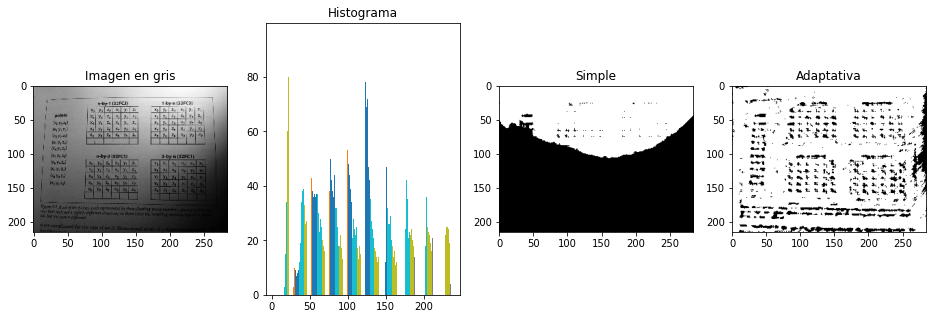

In [ ]:
#Importar librerías
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada
img = img_read('res/original-thresholding.png',"gray")

#Aplicar un filtro de mediana a la imagen
blurred = cv.medianBlur(img,5)

#Realizar una umbralización para valores entre 127 y 255 de la imagen, binaria
ret,th1 = cv.threshold(blurred,127,255,cv.THRESH_BINARY)

#Realizar una umbralización adaptativa de tipo Gaussiana
th2 = cv.adaptiveThreshold(blurred,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,51,2)

#Generar un subplot 1x4 que muestre imagen en gris, histograma y umbralizaciones
fig, ax = plt.subplots(1,4, figsize=(16, 5))

ax[0].set_title('Imagen en gris')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Histograma')
ax[1].hist(blurred)
ax[2].set_title('Simple')
ax[2].imshow(th1, cmap='gray')
ax[3].set_title('Adaptativa')
ax[3].imshow(th2, cmap='gray')


## 4.4. UMBRALIZACIÓN POR OTSU

Otro tipo de umbralización es la Umbralización con Umbral Automático (Otsu) en la cual se halla de forma automática el umbral:

- Se selecciona un valor inicial para U
- Se segmenta la imagen usando U, entonces se producirán dos grupos de píxeles: G1 (que contiene píxeles con nivel de gris > U) y G2 ( que contiene píxeles con nivel de gris ≤ U)
- Se calcula el promedio del nivel de gris µ1 del grupo G1 y el promedio del nivel de gris µ2 del grupo G2
- Calcular el nuevo umbral como U = (µ1 + µ2)/2
- Repetir los pasos 2 a 4 hasta que la diferencia en U en dos iteraciones consecutivas sea menor que un parámetro definido

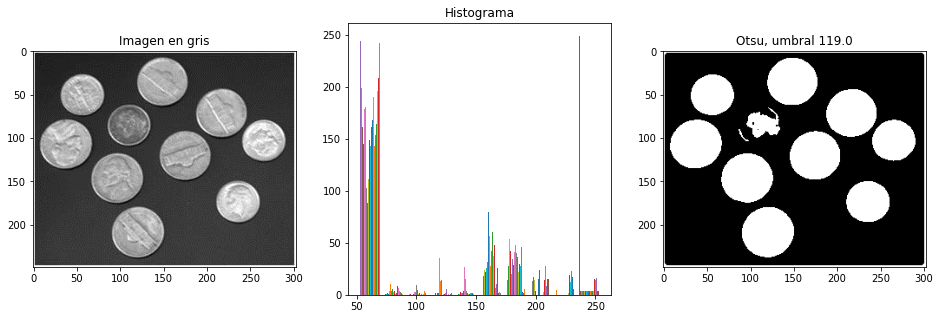

In [ ]:
#Importar librerías
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

#Leer imagen de entrada
img = img_read('res/coins.png',"gray")

#Aplicar filtro de mediana
blurred = cv.medianBlur(img,5)

#Realizar una umbralización Otsu y asignar valroes entre 0 y 255 con umbral 119.0
ret1,th1 = cv.threshold(blurred,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

#Generar un subplot 1x3 que muestre imagen en gris, histograma y Umbralización Otsu
fig, ax = plt.subplots(1,3, figsize=(16, 5))

ax[0].set_title('Imagen en gris')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Histograma')
ax[1].hist(blurred)
ax[2].set_title('Otsu, umbral ' + str(ret1))
ax[2].imshow(th1, cmap='gray')


Pese a sus ventajas, el método de Otsu no puede obtener buenos resultados si el histograma no permite separación. Para este propósito puede ser interesante realizar umbralización adaptativa o multi-umbral con base en Otsu.

En todo caso, hay imágenes como las siguientes en las que la umbralización siempre es complicada:

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg11.png\" alt="" style="width:800px">

Y otras para las que es imposible determinar una umbralización eficiente:

<center><i>Figura. Segmentación.</i></center>
<img src="res/sg12.png\" alt="" style="width:800px">

El principal problema es si es posible y, en caso afirmativo, cómo elegir un umbral adecuado o una serie de umbrales para separar uno o más objetos de su fondo. En muchos casos prácticos, el umbral simple es incapaz de segmentar los objetos de interés.

# 5 SEGMENTACIÓN BASADA EN REGIONES


La Segmentación Basada en Regiones se caracterizan porque construyen las regiones directamente, trabajan mejor en imágenes con ruido, en donde los bordes son difíciles de detectar, usan información de la conectividad para crear las regiones.


# 5.1 K-MEDIAS

El algoritmo K-medias propuesto por MacQueen en el año 1967 es un algoritmo que permite descubrir agrupamientos en conjuntos de datos.

<center><i>Figura. K-Medias.</i></center>
<img src="res/kmed.png\" alt="" style="width:800px">

K-medias es un método que tiene como objetivo generar una partición de un conjunto de n observaciones en k grupos. Cada grupo está representado por el promedio de los puntos que lo componen. El representante de cada grupo se denomina centroide. La cantidad de grupos a descubrir, k, es un parámetro que se debe fijar a priori. El método de clustering comienza con k centroides ubicados de forma aleatoria, y asigna cada observación al centroide más cercano. Después de asignarlos, los centroides se mueven a la ubicación promedio de todos los datos asignados a él, y se vuelven a reasignar los puntos de acuerdo a las nuevas posiciones de los centroides.

¿Por qué funciona?

El objetivo de K-medias es agrupar a las observaciones de forma tal que todas las que se encuentren en el mismo grupo sean lo más semejantes entre sí y que las pertenecientes a grupos distintos sean lo más desemejantes entre sí. Las medidas de distancia, como la euclídea, son utilizadas para medir la semejanza y desemejanza. Una medida para indicar cuán bien los centroides representan a los miembros de su grupo es la suma de los errores al cuadrado. K-medias, en cada iteración, intenta reducir el valor de la suma de los errores al cuadrado. La medida consiste en la sumatoria de las distancias al cuadrado de cada observación al centroide de su grupo:

http://163.10.22.82/OAS/Agrupamiento_Kmedias/definicin.html

Parámetros de **entrada** de la implementación en OpenCV:

- samples : It should be of np.float32 data type, and each feature should be put in a single column.
- nclusters(K) : Number of clusters required at end
- criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `(type, max_iter, epsilon)`: type of termination criteria. It has 3 flags as below:
            - cv2.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
            - cv2.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
            - cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
            
- max_iter - An integer specifying maximum number of iterations.
- epsilon - Required accuracy
- attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.
- flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv2.KMEANS_PP_CENTERS and cv2.KMEANS_RANDOM_CENTERS.

Parámetros de **salida** de la implementación en OpenCV:


- compactness : It is the sum of squared distance from each point to their corresponding centers.
- labels : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
- centers : This is array of centers of clusters.


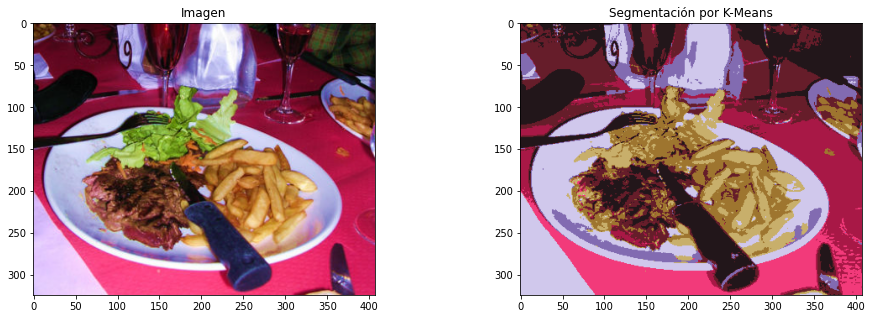

In [ ]:
#Importar librerías
import numpy as np
import cv2

#Leer imagen de entrada
img = img_read('res/dinner.png', "color")

#Reorganizar la imagen de entrada y darle unidades flotantes
Z = img.reshape((-1,3))
Z = np.float32(Z)

# definir criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

#Volver a tipo de dato uint8 y mostrar la imagen
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

#Generar un subplot 1x2 y mostrar imagen junto a segmentación por K-means
fig, ax = plt.subplots(1,2, figsize=(16, 5))

ax[0].set_title('Imagen')
ax[0].imshow(img, cmap='gray')
ax[1].set_title('Segmentación por K-Means')
ax[1].imshow(res2, cmap='gray')


## 5.2 SEGMENTACIÓN WATERSHED

La Segmentación por Watershed Es una técnica que consiste en  interpretar  la  imagen  como  una  superficie topográfica  donde  el  nivel de gris de un punto indica la altitud en dicho punto, es decir, la imagen se considera un gráfico 3D.

La idea básica consiste en utilizar los mínimos locales de la imagen como un conjunto de cuencas en las que se irá vertiendo agua.

Llega un punto en el que si seguimos llenando una cuenca  esta se desbordaría,  por tanto, para evitar este desbordamiento se  construye  un  dique (o presa) para  evitar que el agua de una cuenca pase a otra.

Estos diques serían los contornos de las imágenes a reconocer.

<center><i>Figura. Segmentación Watershed.</i></center>
<img src="res/wat.png\" alt="" style="width:500px">

Se consideran 3 tipos de puntos:

- Puntos que pertenecen a un mínimo de una región

- Puntos ladera, si cae agua en ellos esta se dirigirá hacia un único punto mínimo.

- Puntos cresta, si cae agua en ellos sería igualmente probable que cayera a varios  mínimos. Estos puntos forman líneas cresta, diques o líneas watershed.


https://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html

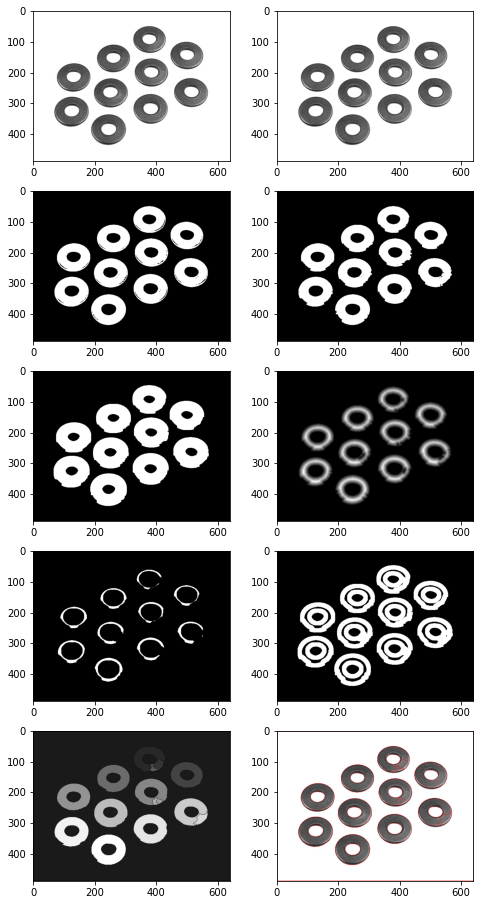

In [ ]:
#Importar librerías
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import copy

#Leer imagen de entrada y convertirla a escala de grises
img = img_read('res/arandelas003.jpg','color')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

#Aplicar una umbralización OTSU
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

#noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)
final=copy.deepcopy(img)
final[markers == -1] = [255,0,0]


images = [img, gray, thresh,opening,sure_bg,dist_transform,sure_fg,unknown,markers,final]

fig, ax = plt.subplots(5,2, figsize=(8, 16))

ax[0][0].imshow(img, cmap='gray')
ax[0][1].imshow(gray, cmap='gray')
ax[1][0].imshow(thresh, cmap='gray')
ax[1][1].imshow(opening, cmap='gray')
ax[2][0].imshow(sure_bg, cmap='gray')
ax[2][1].imshow(dist_transform, cmap='gray')
ax[3][0].imshow(sure_fg, cmap='gray')
ax[3][1].imshow(unknown, cmap='gray')
ax[4][0].imshow(markers, cmap='gray')
ax[4][1].imshow(final, cmap='gray')



# ALGORITMOS DE INTERÉS

Existen tantos algoritmos de segmentación que es imposible tratarlos todos en el contexto de un curso general. Algunos métodos de interés para revisión son:

- Segmentación basada en prominencia/saliency: https://ivrl.epfl.ch/research-2/research-current/research-saliency/
- Umbralización Multiespectral: https://www.researchgate.net/publication/266350425_Thresholding_Techniques_applied_for_Segmentation_of_RGB_and_multispectral_images
- Grab Cut: https://docs.opencv.org/3.4.2/d8/d83/tutorial_py_grabcut.html
- Contornos Activos: http://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html
- División por superpíxeles (SLIC): https://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/ https://arxiv.org/pdf/1808.06759.pdf
- Modelos ocultos de Markov para segmentación: https://inf.u-szeged.hu/~ssip/2008/presentations2/Kato_ssip2008.pdf
- Arquitecturas de redes neuronales para segmentación (UNET): https://towardsdatascience.com/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-70f0f17f46c6

